In [1]:
import Pkg
Pkg.activate("scripts") # Change this to "." incase your "scripts" is already your working directory

In [3]:
using OrdinaryDiffEq, Flux, Optimisers, ParameterSchedulers, Random

# Not registered packages, add them manually (see comment in the Readme.md)
using LVModels, NODEData

In [4]:
Random.seed!(1234) # We set a random seed to have reproducible results

TaskLocalRNG()

In [5]:
# Define the 5D Lotka-Volterra model
function lotka_volterra_5d!(du, u, p, t)
    x, y, z, w, v = u
    α, β, γ, δ, η, ζ, κ, σ, λ, μ, ν, ω, τ = p

    du[1] = α*x - β*x*y
    du[2] = -γ*y + δ*x*y - η*y*z
    du[3] = -ζ*z + κ*y*z - σ*z*w
    du[4] = -λ*w + μ*z*w - ν*w*v 
    du[5] = -ω*v + τ*w*v
end

# Model parameters and initial conditions
p = Float32.([1.0, 0.1, 1.0, 0.5, 0.1, 1.0, 0.5, 0.1, 1.0, 0.05, 0.05, 0.8, 0.02])
tspan, dt = (0f0, 50f0), 0.1f0
u0 = Float32.([6.5, 9.5, 19.5, 20.5, 15.5])

# Solve the ODE
sol = solve(ODEProblem(lotka_volterra_5d!, u0, tspan, p), Tsit5(), saveat=dt)

# Create dataset with randomly missing values
t, X_sparse, mask = sparsify_data(sol) # 0% missing values for species v
train, valid = NODEDataloader(X_sparse, t, 2; valid_set=0.2)

(NODEData{Matrix{Float32},Int64} with 400 batches with length 2, NODEData{Matrix{Float32},Int64} with 99 batches with length 2)

In [6]:
# Define neural ODE model
N_weights = 256
U_nn = Chain(Dense(5, N_weights, swish), Dense(N_weights, N_weights, swish), Dense(N_weights, 5))
θ, U_re = Flux.destructure(U_nn)
p_ln = LearnableParams(θ, Float32[0.0]) # Learnable decay parameter

function neural_ode(u, p_ln::LearnableParams, t)
    x, y, z, w, v = u
    U = U_re(p_ln.θ)(u)
    [1.0f0 * x + U[1], -1.0f0 * y + U[2], -1.0f0 * z + U[3], -1.0f0 * w + U[4], -0.8f0 * v + U[5]]
end

model = NDE(ODEProblem(neural_ode, u0, (0f0, dt), p_ln); reltol=1e-5, dt=dt)

NDE{LearnableParams{Vector{Float32}}, ODEProblem{Vector{Float32}, Tuple{Float32, Float32}, false, LearnableParams{Vector{Float32}}, ODEFunction{false, SciMLBase.AutoSpecialize, typeof(neural_ode), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}, Base.Pairs{Symbol, AbstractFloat, Tuple{Symbol, Symbol}, @NamedTuple{reltol::Float64, dt::Float32}}}(LearnableParams{Vector{Float32}}(Float32[0.05958367, 0.007822249, 0.10261122, 0.103295684, 0.05028987, 0.007261923, 0.10928871, -0.14772418, 0.09610284, -0.028586268  …  -0.06934105, -0.14850052, 0.14951907, 0.019829335, 0.10279498, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0]), ODEProblem{Vector{Float32

In [7]:
# Training setup
opt_state = Optimisers.setup(Optimisers.Adam(1f-3), model)

τ_min, τ_max, epochs = 2, 7, 20
NN_train, NN_valid = min(100, length(train)), min(100, length(valid))
scheduler = CosAnneal(1f-3, 0f0, epochs, false)

CosAnneal{Float32, Int64}(0.001f0, 0.0f0, 20, false)

In [8]:
# Training loop 
Train = false
if Train
    println("Training started...")
    for i_τ in τ_min:τ_max
        train_τ = NODEDataloader(X_sparse, t, i_τ)
        @info "Batch size = $(i_τ)"

        for epoch in 1:epochs
            η = Float32(scheduler(epoch))
            Optimisers.adjust!(opt_state, η)

            for (batch_t, batch_data) in train_τ
                batch_mask = get_mask_for_batch(batch_t, mask, t[1], dt)
                Flux.train!(model, [(batch_t, batch_data)], opt_state) do m, bt, bd
                    loss(m, (bt, bd), bd, batch_mask)
                end
            end

            train_loss = mean([loss(model, train[i], train[i][2], get_mask_for_batch(train[i][1], mask, t[1], dt)) for i in 1:NN_train])
            valid_loss = mean([loss(model, valid[i], valid[i][2], get_mask_for_batch(valid[i][1], mask, t[1], dt)) for i in 1:NN_valid])
            @printf("Epoch %3d | LR: %.2e | Train Loss: %.4f | Valid Loss: %.4f\n", epoch, η, train_loss, valid_loss)

        end
    end
end

In [9]:
# Prediction for the trained NODE
@load "trained NODEs\\lv_5d_scenario1.jld2" model # Load the trained model; path relative to scripts

train_70 = NODEDataloader(X_sparse, t, 70) # Training batches of size 70 for L2 error plot
mask1 = X_sparse[5, :] .!= 0  # Logical mask for nonzero elements
# Using β = p[2], δ = p[4], η = p[5], κ = p[7], σ = p[8], μ = p[10], ν = p[11], and τ = p[13]
U_truth1 = -p[2] .* X_sparse[1, mask1] .* X_sparse[2, mask1]
U_truth2 = p[4] .* X_sparse[1, mask1] .* X_sparse[2, mask1] .- p[5] .* X_sparse[2, mask1] .* X_sparse[3, mask1]
U_truth3 = p[7] .* X_sparse[2, mask1] .* X_sparse[3, mask1] .- p[8] .* X_sparse[3, mask1] .* X_sparse[4, mask1]
U_truth4 = p[10] .* X_sparse[3, mask1] .* X_sparse[4, mask1] .- p[11] .* X_sparse[4, mask1] .* X_sparse[5, mask1]
U_truth5 = p[13] .* X_sparse[4, mask1] .* X_sparse[5, mask1]
U_truth = vcat(U_truth1', U_truth2', U_truth3', U_truth4', U_truth5')

plt_traj, plt_interaction, plt_l2_error, plt_re = plot_model_performance(sol, t, X_sparse, train_70, model, U_re, U_truth, mask, dt)

(Plot{Plots.GRBackend() n=10}, Plot{Plots.GRBackend() n=10}, Plot{Plots.GRBackend() n=1}, Plot{Plots.GRBackend() n=10})

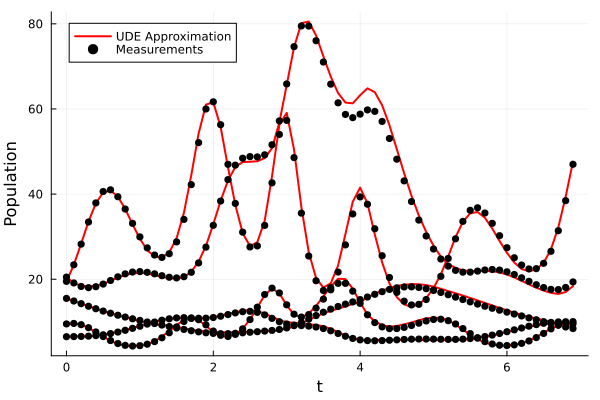

In [10]:
display(plt_traj)

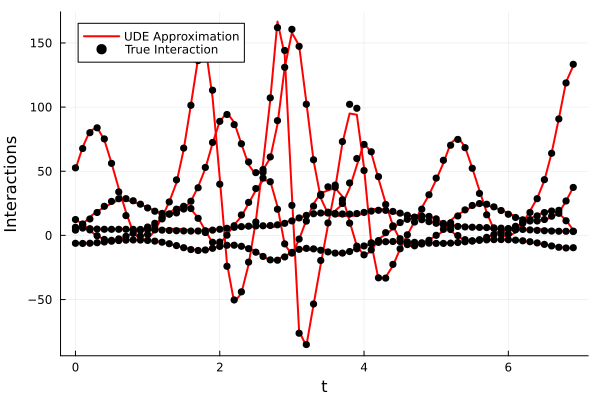

In [11]:
display(plt_interaction)

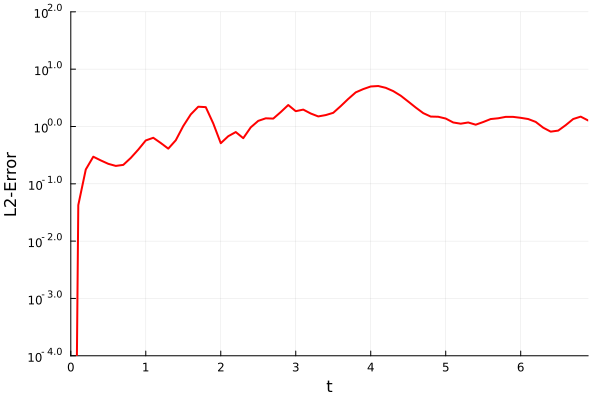

In [12]:
display(plt_l2_error)

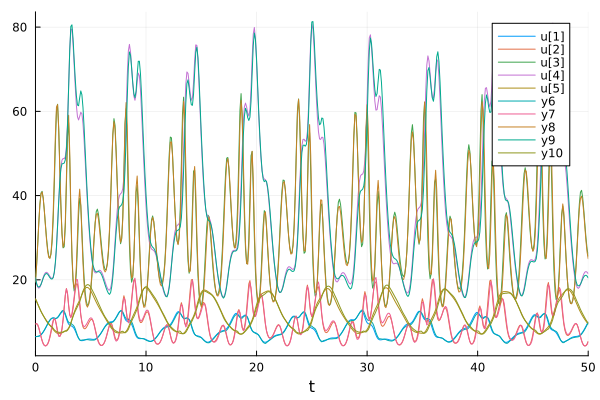

In [13]:
display(plt_re)

In [14]:
# Extract learned interactions from the neural network
mlp = U_re(model.p.θ)
dx = mlp(X_sparse)

5×501 Matrix{Float32}:
 -6.05442  -6.0595   -6.3697   -6.13253   …  -3.79437  -4.3183   -5.32896
 12.2542    9.02079   3.72229  -0.601071      6.45385   9.08216  13.5056
 51.5417   68.8125   81.3418   84.1214       -3.23653   3.6486   14.3139
  4.00366   8.76684  14.3268   18.8642       21.9978   19.5437   16.8802
  6.28436   5.68072   5.49091   5.23045       4.05512   4.41618   4.61703

In [15]:
# Perform symbolic regression using the trained NODE
hall_of_fame, pareto_frontiers = perform_symbolic_regression(X_sparse, dx)
display(pareto_frontiers[1][3].tree) 
display(pareto_frontiers[2][3].tree) 
display(pareto_frontiers[3][3].tree) 
display(pareto_frontiers[4][3].tree) 
display(pareto_frontiers[5][3].tree) 

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\adity\.julia\packages\ProgressMeter\kVZZH\src\ProgressMeter.jl:594
Evolving for 100 iterations... 100%|█████████████████████| Time: 0:02:24


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.260e+01  1.594e+01  y = x₂
3           9.858e+00  4.148e-01  y = x₄ * 0.23755
5           5.867e-01  1.411e+00  y = (x₄ * x₅) * 0.019945
7           5.842e-01  2.170e-03  y = ((x₄ * x₅) * 0.019782) + 0.10196
9           5.685e-01  1.362e-02  y = (x₄ * x₅) * ((x₂ * -6.6784e-05) + 0.020741)
11          5.626e-01  5.212e-03  y = (x₄ * x₅) * ((x₂ * (x₂ * -3.0525e-06)) + 0.020421)
13          5.523e-01  9.211e-03  y = x₄ * (x₅ * (((0.00028444 - (x₂ * 1.417e-05)) * x₂) + 0...
                                      .018764))
15          5.343e-01  1.660e-02  y = ((x₄ + (-4.0031 + (x₂ * (0.88519 - (x₂ * 0.046))))) * ...
                                      x₅) * 0.020169
17          5.214e-01  1.218e-02  y = (x₅ * ((((x₄ * -0.23356) + x₂) * (0.9184 - (x₂ * 0.088...
                                      124))) + x₄)) * 0.020137
19          

[ Info: Final population:
[ Info: Results saved to:


(x1 * x2) * -0.09999995

(x1 * 5.003945) - x3

(x2 * 7.4751425) - x4

(x4 * x3) * 0.03488973

(x4 * x5) * 0.019944554